In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

from astropy.visualization import quantity_support
import matplotlib
from matplotlib import cm
import astropy.units as u
import glob
import os

font = {'size'   : 22}

matplotlib.rc('font', **font)
from astroduet.lightcurve import get_lightcurve

In [2]:
lcs = []
labels = []
for lcfile in sorted(glob.glob("../astroduet/data/*_lightcurve_DUET.fits")):
    lc = get_lightcurve(lcfile, distance=100e6*u.pc, phase_start=0.5)
    lcs.append(lc)
    labels.append(os.path.basename(lcfile).replace('_lightcurve_DUET.fits', ''))
# lcIIp = get_lightcurve("../astroduet/data/SNIIp_lightcurve_DUET.fits", distance=100e6*u.pc, 
#                        phase_start=0.5)

Effective PSF size 7.337363286630968 arcsec
Number of effective bgd pixels: 3.597839101366366

Effective PSF size 7.337363286630968 arcsec
Number of effective bgd pixels: 3.597839101366366

Effective PSF size 7.337363286630968 arcsec
Number of effective bgd pixels: 3.597839101366366

Effective PSF size 7.337363286630968 arcsec
Number of effective bgd pixels: 3.597839101366366

Effective PSF size 7.337363286630968 arcsec
Number of effective bgd pixels: 3.597839101366366

Effective PSF size 7.337363286630968 arcsec
Number of effective bgd pixels: 3.597839101366366

Effective PSF size 7.337363286630968 arcsec
Number of effective bgd pixels: 3.597839101366366

Effective PSF size 7.337363286630968 arcsec
Number of effective bgd pixels: 3.597839101366366

Effective PSF size 7.337363286630968 arcsec
Number of effective bgd pixels: 3.597839101366366

Effective PSF size 7.337363286630968 arcsec
Number of effective bgd pixels: 3.597839101366366



In [3]:
def plot_lcs(lightcurves, labels=None):

    plt.figure(figsize=(15, 15))
    colors = cm.rainbow(np.linspace(0, 1, len(lightcurves)))
    gs = plt.GridSpec(6, 2)
    ax0 = plt.subplot(gs[0:2, 0])
    ax1 = plt.subplot(gs[4:6, 0], sharex=ax0)
    ax2 = plt.subplot(gs[2:4, 0], sharex=ax0)
    ax3 = plt.subplot(gs[0:3, 1])
    ax4 = plt.subplot(gs[3:6, 1])
    if labels is None:
        labels = [f"lc{i}" for i in range(len(lightcurves))]
    ax1.semilogx();

    for i, lightcurve in enumerate(lightcurves):
        label=labels[i]
        print(label)
        if len(lightcurve['time']) < 1:
            print("bad")
            continue
        lightcurve['Dmag'] = lightcurve['ABmag_D1'] - lightcurve['ABmag_D2']
        lightcurve['time'] -= lightcurve['time'][0]
        
#         dtimes = (lightcurve['time'].value[1] + lightcurve['time'].value[0]) / 2
        dtimes = (lightcurve['time'].value[1] - lightcurve['time'].value[0])

        dDlc = np.diff(lightcurve['Dmag'].value) / dtimes
        dlc = np.diff(lightcurve['ABmag_D1'].value) / dtimes
        
        color = colors[i]
        good = (lightcurve['snr_D1'].value > 1) | (lightcurve['snr_D2'].value > 1)
        lightcurve = lightcurve[good]
        size = np.log10(lightcurve['snr_D1'].value) * 5
        ax0.errorbar(lightcurve['time'].value / 86400, lightcurve['ABmag_D1'].value, 
                     fmt='none', markersize=size, yerr=lightcurve['ABmag_D1_err'].value, color=color)
        ax0.errorbar(lightcurve['time'].value / 86400, lightcurve['ABmag_D2'].value, 
                     fmt='none', markersize=size, yerr=lightcurve['ABmag_D2_err'].value, color=color)
        ax0.scatter(lightcurve['time'].value / 86400, lightcurve['ABmag_D1'].value, 
                    s=size, color=color)
        ax0.scatter(lightcurve['time'].value / 86400, lightcurve['ABmag_D2'].value, 
                    s=size, color=color)

        ax1.scatter(lightcurve['time'].value / 86400, lightcurve['snr_D1'].value, s=size, marker='o', c=[color])
        ax1.scatter(lightcurve['time'].value / 86400, lightcurve['snr_D2'].value, s=size, marker='s', c=[color])
        ax2.scatter(lightcurve['time'].value / 86400, 
                    lightcurve['Dmag'].value, 
                    s=size, c=[color], label=label)
        ax3.scatter(lightcurve['Dmag'].value, 
                    lightcurve['ABmag_D1'].value, 
                    s=size, c=[color], label=label)
        ax4.scatter(dDlc, dlc, s=size, c=[color], label=label)

    ax0.set_ylabel("AB mag")
    ax1.set_ylabel("S/R")
    ax2.set_ylabel(r"$\Delta$ mag")
    ax1.set_xlabel("Time (d)")
#         ymin = min(lightcurve['ABmag_D1'].value.min(), lightcurve['ABmag_D2'].value.min()) - 1
#         ymax = max(lightcurve['ABmag_D1'].value.max(), lightcurve['ABmag_D2'].value.max()) + 1
#         # Inverted ax for magnitude
    ax0.set_xlim([0.01, None])
    ax2.legend()
    ax3.set_xlabel("AB mag 1")
    ax3.set_ylabel(r"$\Delta$ mag")
    ax4.set_xlim([-0.0002, 0.0005])
    ax4.set_ylim([-0.0005, 0.0015])
    ax4.set_ylabel("d(AB mag 1) / dt")
    ax4.set_xlabel(r"d($\Delta$ mag) / dt")
#     ax3.set_xlim([30, 10])
#     ax0.set_xlim()



H-strippedSN
SNIIb
SNIIp-large
SNIIp
blukn_01
blukn_02
blukn_04
shock_1e11
shock_2.5e10
shock_5e10


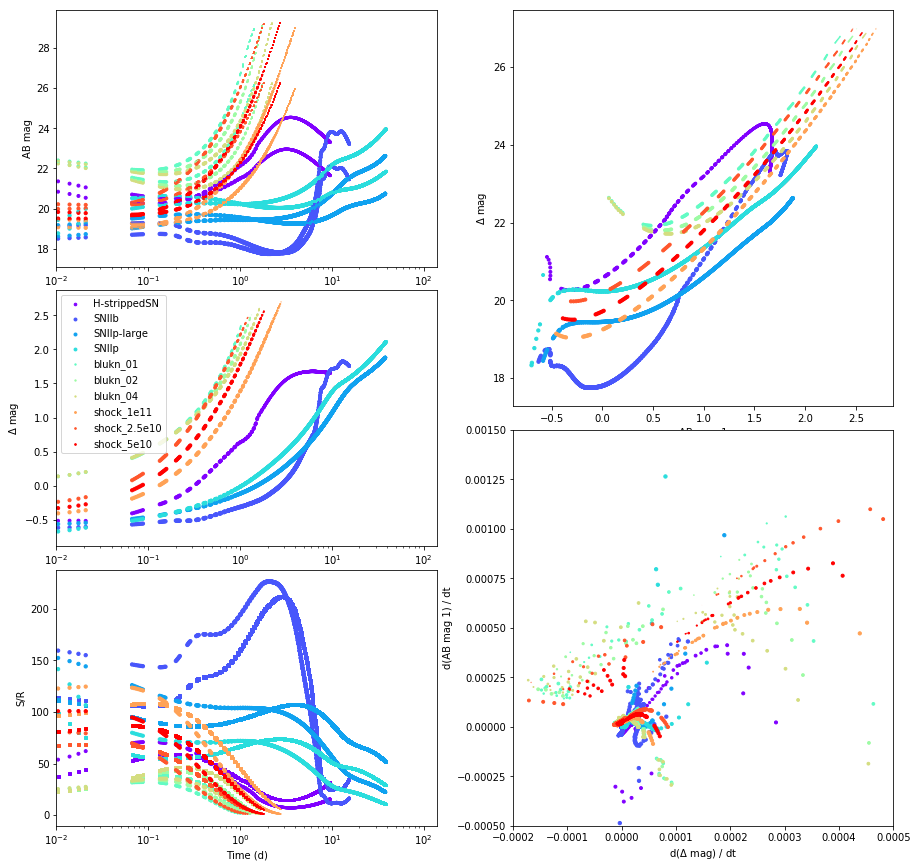

In [4]:
plot_lcs(lcs, labels)